In [1]:
# Librerías básicas
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

import seaborn as sns
sns.set()

# El módulo Statsmodels

Statsmodels es un módulo de Python que ofrece clases y funciones de varios modelos estadísticos, así como pruebas de hipótesis 
y análisis exploratorio de datos. La documentación se encuentra en <a href='https://www.statsmodels.org/stable/index.html'>statsmodels.org</a>. 

In [3]:
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.graphics.tsaplots as sgt
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats.distributions import chi2
import statsmodels.tsa.stattools as sts 

# Fuentes de datos interesantes

## API de Yahoo finance

Yahoo Finance tiene una API que permite descargar información financiera para realizar análisis. La página web original de la documentación ya no existe. Sin embargo, existen algunas páginas de documentación no oficial como <a href= 'https://github.com/mxbi/yahoo-finance-api.git'> este repositorio en GitHub, </a> o <a href='https://python-yahoofinance.readthedocs.io/en/latest/api.html'> esta página de documentación the ReadTheDocs </a>.

In [6]:
# Instalación de yfinance
%pip install yfinance

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [7]:
# Se importa la librería yfinance
import yfinance

In [8]:
# Se descargan los datos S&P500 y Nikkei225
df_yfinance_raw = yfinance.download(tickers = "^GSPC ^N225", #Las series de tiempo de interés - (en nuestro caso, S&P500 y NIKKEI225)
                              start = "1994-01-07", #Fecha inicial
                              end = "2024-08-27", #Fecha final
                              interval = "1d", #Frecuencia.
                              group_by = 'ticker', #Criterio de agrupación. Usualmente "ticker"
                              auto_adjust = True#,  
                              #threads = True
                               ) #. 

[*********************100%***********************]  2 of 2 completed


In [9]:
df_yfinance_raw.head()

Ticker             ^N225                                                   \
Price               Open          High           Low         Close Volume   
Date                                                                        
1994-01-07  17842.980469  18131.410156  17787.480469  18124.009766    0.0   
1994-01-10  18186.519531  18567.060547  18186.519531  18443.439453    0.0   
1994-01-11  18481.849609  18671.669922  18373.039062  18485.250000    0.0   
1994-01-12  18447.339844  18807.080078  18301.929688  18793.880859    0.0   
1994-01-13  18770.380859  18823.380859  18548.750000  18577.259766    0.0   

Ticker           ^GSPC                                                   
Price             Open        High         Low       Close       Volume  
Date                                                                     
1994-01-07  467.089996  470.260010  467.029999  469.899994  324920000.0  
1994-01-10  469.899994  475.269989  469.549988  475.269989  319490000.0  
1994-01-11  475.269989  475.279999  473.269989  474.130005  305490000.0  
1994-01-12  474.130005  475.059998  472.140015  474.170013  310690000.0  
1994-01-13  474.170013  474.170013  471.799988  472.470001  277970000.0

In [10]:
# Se crea una copia para modificar
df_yfinance = df_yfinance_raw.copy()

In [11]:
# Se agregan columnas para el nivel de cierre de los índices S&P500 y Nikkei255
df_yfinance['spx'] = df_yfinance['^GSPC'].Close
df_yfinance['nikkei'] = df_yfinance['^N225'].Close

In [12]:
#f_comp = df_comp.iloc[1:] # Removing the first elements, since we always start 1 period before the first, due to time zone differences of closing prices
del df_yfinance['^N225'] # Se retiran los grupos de columnas '^N225' y '^GSPC'
del df_yfinance['^GSPC']
df_yfinance=df_yfinance.asfreq('b') # Se establece la frecuencia de los datos
df_yfinance=df_yfinance.fillna(method='ffill') # Se rellenan los datos faltantes con el método ffill que usa el último valor válido

In [13]:
df_yfinance.head()

Ticker,spx,nikkei
Price,,
Date,,
1994-01-07,469.899994,18124.009766
1994-01-10,475.269989,18443.439453
1994-01-11,474.130005,18485.250000
1994-01-12,474.170013,18793.880859
1994-01-13,472.470001,18577.259766


In [14]:
df_yfinance.columns

MultiIndex([(   'spx', ''),
            ('nikkei', '')],
           names=['Ticker', 'Price'])

In [15]:
df_yfinance.columns=['spx','nikkei']

In [16]:
df_yfinance.columns

Index(['spx', 'nikkei'], dtype='object')

In [17]:
df_yfinance.head() 

,spx,nikkei
Date,,
1994-01-07,469.899994,18124.009766
1994-01-10,475.269989,18443.439453
1994-01-11,474.130005,18485.250000
1994-01-12,474.170013,18793.880859
1994-01-13,472.470001,18577.259766


In [18]:
df_yfinance.columns

Index(['spx', 'nikkei'], dtype='object')

In [19]:
df_yfinance.index = pd.to_datetime(df_yfinance.index)

In [20]:
df_yfinance.tail() # Making sure of the last day we're including in the series

,spx,nikkei
Date,,
2024-08-20,5597.120117,38062.921875
2024-08-21,5620.850098,37951.800781
2024-08-22,5570.640137,38211.011719
2024-08-23,5634.609863,38364.269531
2024-08-26,5616.839844,38110.218750


In [21]:
#df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
#df_comp.set_index("date", inplace=True)
df_yfinance=df_yfinance.asfreq('b')
df_yfinance=df_yfinance.fillna(method='ffill')

In [22]:
df_yfinance.head()

,spx,nikkei
Date,,
1994-01-07,469.899994,18124.009766
1994-01-10,475.269989,18443.439453
1994-01-11,474.130005,18485.250000
1994-01-12,474.170013,18793.880859
1994-01-13,472.470001,18577.259766


In [23]:
df_yfinance.index = pd.to_datetime(df_yfinance.index).tz_localize(None)

## Algunos archivos csv con datos

En <a href='https://github.com/jbrownlee/Datasets.git'>este repositorio de GitHub</a> se encuentran muchos archivos .csv con datos apropiados para ejercicios de aprendizaje de máquina y series de tiempo. En este notebook utilizaremos el archivo 'airline_passengers.csv'.

In [25]:
df_airline = pd.read_csv('airline_passengers.csv',index_col='Month',parse_dates=True)

In [26]:
df_airline.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [27]:
df_airline.index = pd.to_datetime(df_airline.index)

## Datos que vienen con la librería statsmodels
La librería <a href='https://www.statsmodels.org/stable/index.html'>statsmodels</a> tiene varios conjuntos de datos incorporados.
En este notebook, utilizaremos el dataset 'macrodata', que trae datos macroeconómicos de EEUU.

In [29]:
#import pandas as pd
import statsmodels.api as sm
df_macrodata = sm.datasets.macrodata.load_pandas().data
df_macrodata.index = pd.Index(sm.tsa.datetools.dates_from_range('1959Q1', '2009Q3'))
print(sm.datasets.macrodata.NOTE)

::
    Number of Observations - 203

    Number of Variables - 14

    Variable name definitions::

        year      - 1959q1 - 2009q3
        quarter   - 1-4
        realgdp   - Real gross domestic product (Bil. of chained 2005 US$,
                    seasonally adjusted annual rate)
        realcons  - Real personal consumption expenditures (Bil. of chained
                    2005 US$, seasonally adjusted annual rate)
        realinv   - Real gross private domestic investment (Bil. of chained
                    2005 US$, seasonally adjusted annual rate)
        realgovt  - Real federal consumption expenditures & gross investment
                    (Bil. of chained 2005 US$, seasonally adjusted annual rate)
        realdpi   - Real private disposable income (Bil. of chained 2005
                    US$, seasonally adjusted annual rate)
        cpi       - End of the quarter consumer price index for all urban
                    consumers: all items (1982-84 = 100, seasonally adju

In [30]:
df_macrodata.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
1959-03-31,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1959-06-30,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
1959-09-30,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
1959-12-31,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
1960-03-31,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [31]:
df_macrodata.index = pd.to_datetime(df_macrodata.index)

## Datos de simulados de ventas

In [33]:
df_ventas = pd.read_excel('Datos_clase_1.xlsx',index_col = 'Fecha', parse_dates = True)

In [34]:
df_ventas.index = pd.to_datetime(df_ventas.index)

# Yahoo finance

## Estacionaridad

In [37]:
sts.adfuller(df_yfinance['spx'])

(2.495421902147278,
 0.9990483594146493,
 32,
 7959,
 {'1%': -3.4311718884675066,
  '5%': -2.861903215555782,
  '10%': -2.566963334958385},
 72367.34132821791)

## PACF y ACF

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


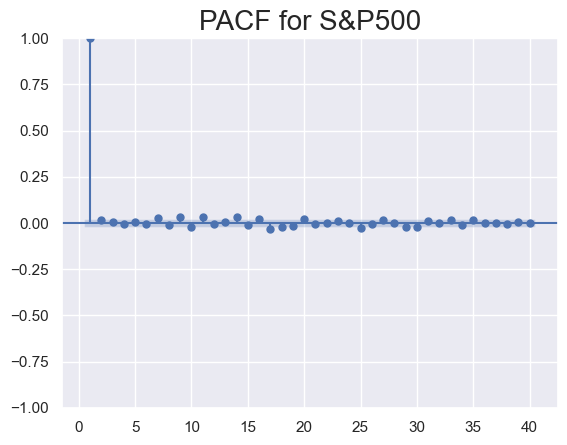

In [39]:
sgt.plot_pacf(df_yfinance['spx'], zero = False, lags = 40)
plt.title("PACF for S&P500", size = 20)
plt.show()

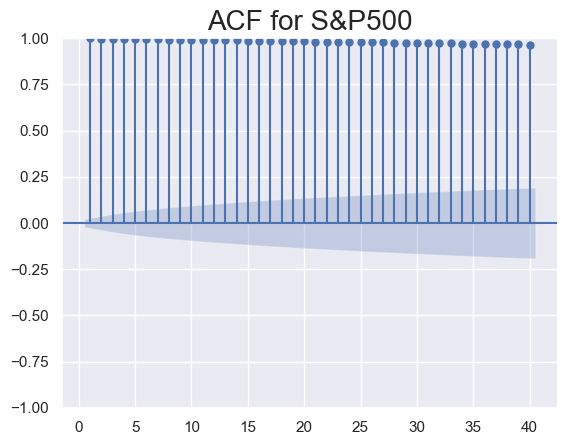

In [40]:
sgt.plot_acf(df_yfinance['spx'], zero = False, lags = 40)
plt.title("ACF for S&P500", size = 20)
plt.show()

## Modelo AR(1)

In [42]:
yfinance_model_ar_1 = ARIMA(df_yfinance['spx'], order=(1,0,0))

In [43]:
yfinance_results_ar_1 = yfinance_model_ar_1.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [44]:
yfinance_results_ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    spx   No. Observations:                 7992
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -36454.616
Date:                Mon, 31 Mar 2025   AIC                          72915.231
Time:                        07:44:39   BIC                          72936.190
Sample:                    01-07-1994   HQIC                         72922.406
                         - 08-26-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1818.9555   1144.491      1.589      0.112    -424.206    4062.117
ar.L1          0.9998      0.000   6308.795      0.000       1.000       1.000
sigma2       535.8763      2.663    201.206      0.000     530.656     541.096
===================================================================================
Ljung-Box (L1) (Q):                  49.71   Jarque-Bera (JB):            117805.78
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               8.68   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
#yfinance_results_ar_1['Date']

In [46]:
yfinance_results_ar_1.get_prediction(start = '2015-01-01',end = '2016-01-01')

In [47]:
start = pd.to_datetime('2015-01-01').tz_localize(None)
end = pd.to_datetime('2016-01-01').tz_localize(None)

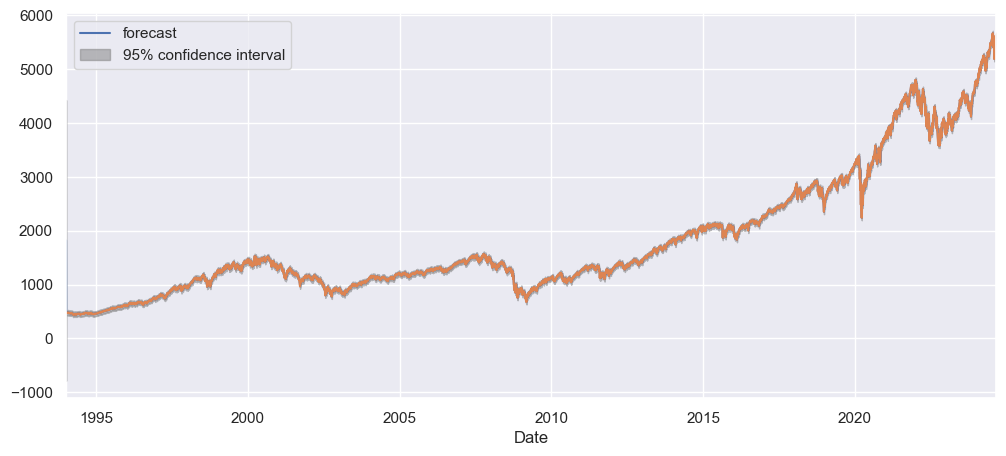

In [48]:
plot_predict(yfinance_results_ar_1)
df_yfinance['spx'].plot(figsize=(12,5));

## Modelo MA(1)

In [50]:
yfinance_model_ma_1 = ARIMA(df_yfinance['spx'], order=(0,0,1))

In [51]:
yfinance_results_ma_1 = yfinance_model_ma_1.fit()

In [52]:
yfinance_results_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    spx   No. Observations:                 7992
Model:                 ARIMA(0, 0, 1)   Log Likelihood              -62328.834
Date:                Mon, 31 Mar 2025   AIC                         124663.668
Time:                        07:44:46   BIC                         124684.627
Sample:                    01-07-1994   HQIC                        124670.843
                         - 08-26-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1818.9199     20.734     87.725      0.000    1778.282    1859.558
ma.L1          0.9886      0.001    848.098      0.000       0.986       0.991
sigma2      3.478e+05   7271.591     47.834      0.000    3.34e+05    3.62e+05
===================================================================================
Ljung-Box (L1) (Q):                7626.21   Jarque-Bera (JB):              2548.71
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.50   Skew:                             1.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

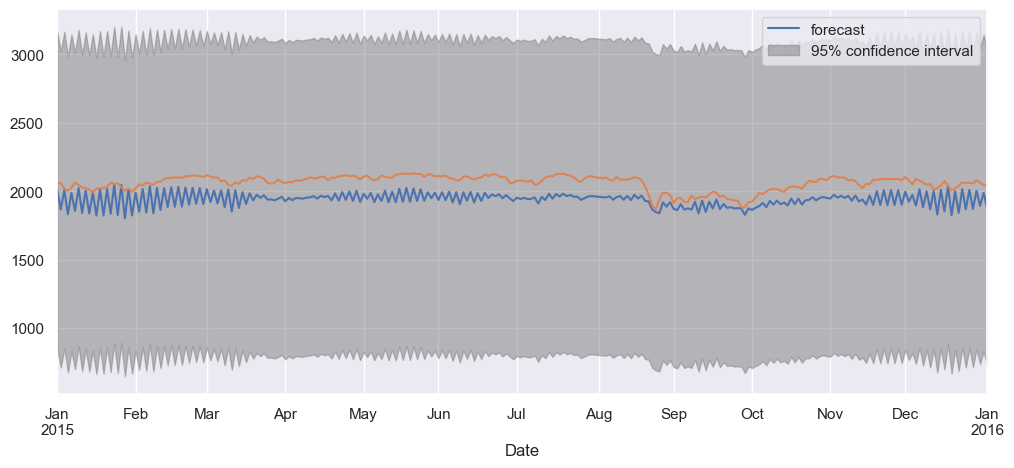

In [53]:
plot_predict(yfinance_results_ma_1, start = '2015-01-01',end = '2016-01-01')
df_yfinance['spx']['2015-01-01':'2016-01-01'].plot(figsize=(12,5));

## AR de mayor complejidad

## Modelos MA más complejos

In [56]:
yfinance_model_ma_5 = ARIMA(df_yfinance['spx'], order=(0,0,5))

In [57]:
yfinance_results_ma_5 = yfinance_model_ma_5.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [58]:
yfinance_results_ma_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    spx   No. Observations:                 7992
Model:                 ARIMA(0, 0, 5)   Log Likelihood              -57674.488
Date:                Mon, 31 Mar 2025   AIC                         115362.976
Time:                        07:45:12   BIC                         115411.880
Sample:                    01-07-1994   HQIC                        115379.716
                         - 08-26-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1818.8057     23.972     75.873      0.000    1771.822    1865.789
ma.L1          0.8476      0.003    271.693      0.000       0.842       0.854
ma.L2          0.2661      0.002    127.163      0.000       0.262       0.270
ma.L3          0.2694      0.003     81.003      0.000       0.263       0.276
ma.L4          0.8485      0.007    122.005      0.000       0.835       0.862
ma.L5          0.9975      0.005    218.310      0.000       0.989       1.006
sigma2      1.102e+05   1896.527     58.115      0.000    1.06e+05    1.14e+05
===================================================================================
Ljung-Box (L1) (Q):                3156.71   Jarque-Bera (JB):              6639.37
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.64   Skew:                             1.67
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Pruebas LLR

In [60]:
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF)
    return p

In [61]:
LLR_test(yfinance_model_ma_1, yfinance_model_ma_5,DF=4)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


0.0

## Modelo ARMA(1,1)

In [63]:
yfinance_model_ar_1_ma_1 = ARIMA(df_yfinance['spx'], order=(1,0,1))

In [64]:
yfinance_results_ar_1_ma_1 = yfinance_model_ar_1_ma_1.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [65]:
yfinance_results_ar_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    spx   No. Observations:                 7992
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -36430.283
Date:                Mon, 31 Mar 2025   AIC                          72868.566
Time:                        07:45:54   BIC                          72896.511
Sample:                    01-07-1994   HQIC                         72878.131
                         - 08-26-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1818.8521   6.07e-05      3e+07      0.000    1818.852    1818.852
ar.L1          1.0000   7.79e-05   1.28e+04      0.000       1.000       1.000
ma.L1         -0.0749      0.004    -18.606      0.000      -0.083      -0.067
sigma2       532.5699      2.777    191.778      0.000     527.127     538.013
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):            106334.12
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               8.60   Skew:                            -0.82
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.61e+20. Standard errors may be unstable.
"""

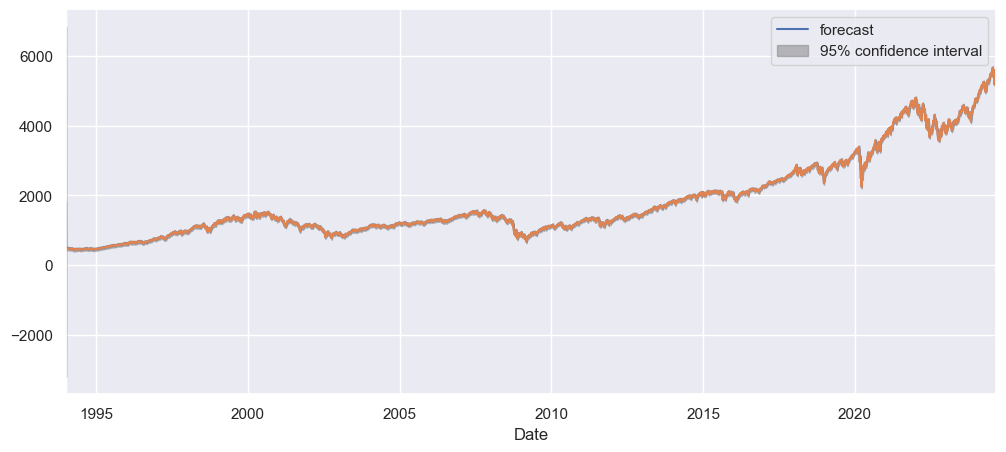

In [66]:
plot_predict(yfinance_results_ar_1_ma_1)
df_yfinance['spx'].plot(figsize=(12,5));

## Modelos ARMA de mayor complejidad

In [68]:
yfinance_model_ar_1_ma_10 = ARIMA(df_yfinance['spx'], order=(1,0,10))

In [69]:
yfinance_results_ar_1_ma_10 = yfinance_model_ar_1_ma_10.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [70]:
yfinance_results_ar_1_ma_10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    spx   No. Observations:                 7992
Model:                ARIMA(1, 0, 10)   Log Likelihood              -36351.318
Date:                Mon, 31 Mar 2025   AIC                          72728.636
Time:                        07:46:53   BIC                          72819.456
Sample:                    01-07-1994   HQIC                         72759.724
                         - 08-26-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1818.8105   3.45e-05   5.27e+07      0.000    1818.810    1818.811
ar.L1          1.0000   7.72e-05   1.29e+04      0.000       1.000       1.000
ma.L1         -0.0623      0.005    -13.317      0.000      -0.071      -0.053
ma.L2          0.0168      0.004      3.784      0.000       0.008       0.026
ma.L3         -0.0193      0.005     -4.290      0.000      -0.028      -0.010
ma.L4          0.0003      0.005      0.062      0.950      -0.010       0.010
ma.L5         -0.0046      0.005     -0.960      0.337      -0.014       0.005
ma.L6         -0.0479      0.005    -10.004      0.000      -0.057      -0.039
ma.L7          0.0498      0.005      9.773      0.000       0.040       0.060
ma.L8         -0.0414      0.005     -8.425      0.000      -0.051      -0.032
ma.L9          0.1007      0.005     19.630      0.000       0.091       0.111
ma.L10        -0.0548      0.005    -10.673      0.000      -0.065      -0.045
sigma2       522.1624      3.224    161.947      0.000     515.843     528.482
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             81055.96
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               8.17   Skew:                            -0.83
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.79e+20. Standard errors may be unstable.
"""

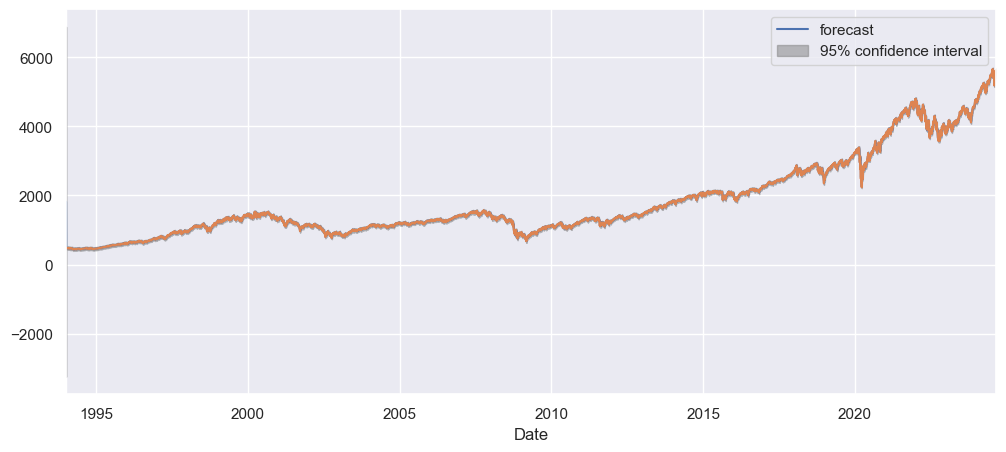

In [71]:
plot_predict(yfinance_results_ar_1_ma_10)
df_yfinance['spx'].plot(figsize=(12,5));

## Pruebas LLR

In [73]:
print("\nARMA vs AR ", LLR_test(yfinance_model_ar_1, yfinance_model_ar_1_ma_1))
print("\nARMA vs MA ", LLR_test(yfinance_model_ma_1, yfinance_model_ar_1_ma_1))
print("\nARMA vs ARMA(1,10) ", LLR_test(yfinance_model_ar_1_ma_1, yfinance_model_ar_1_ma_10,DF=9))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'



ARMA vs AR  3.035488024490658e-12


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'



ARMA vs MA  0.0


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'



ARMA vs ARMA(1,10)  1.9987439360996618e-29


## Modelo ARIMA(1,1,1)

In [75]:
yfinance_model_ar_1_i_1_ma_1 = ARIMA(df_yfinance['spx'], order=(1,1,1))

In [76]:
yfinance_results_ar_1_i_1_ma_1 = yfinance_model_ar_1_i_1_ma_1.fit()

In [77]:
yfinance_results_ar_1_i_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    spx   No. Observations:                 7992
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -36417.273
Date:                Mon, 31 Mar 2025   AIC                          72840.546
Time:                        07:48:30   BIC                          72861.504
Sample:                    01-07-1994   HQIC                         72847.720
                         - 08-26-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3613      0.040     -9.039      0.000      -0.440      -0.283
ma.L1          0.2840      0.041      6.846      0.000       0.203       0.365
sigma2       532.0823      2.807    189.540      0.000     526.580     537.584
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            103699.42
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               8.57   Skew:                            -0.79
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

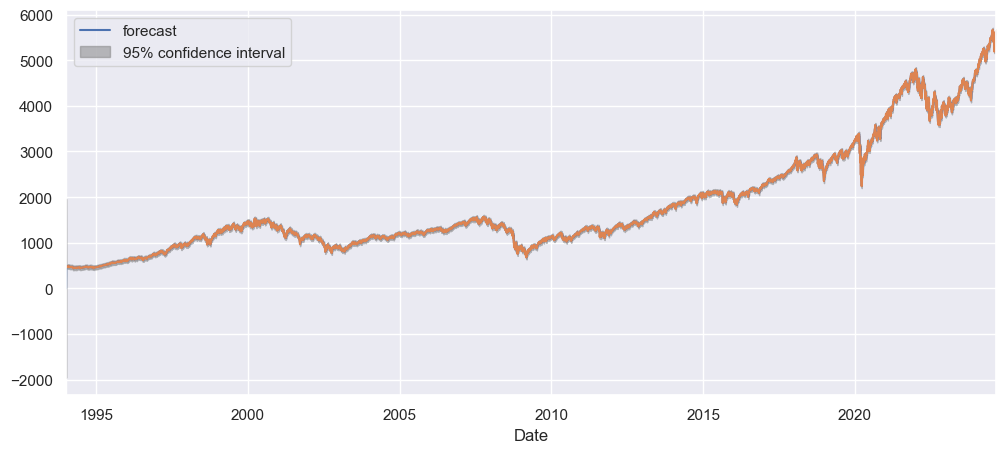

In [78]:
plot_predict(yfinance_results_ar_1_i_1_ma_1)
df_yfinance['spx'].plot(figsize=(12,5));

## Modelos ARIMA de mayor complejidad

### PACF y ACF de resíduos

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


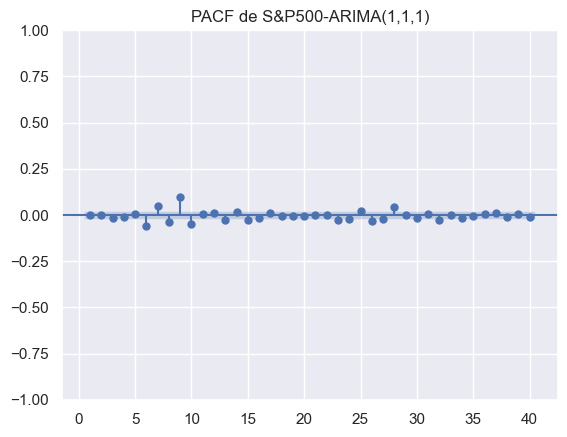

In [81]:
sgt.plot_pacf(yfinance_results_ar_1_i_1_ma_1.resid.iloc[1:], zero = False, lags = 40)
plt.title("PACF de S&P500-ARIMA(1,1,1)")
plt.show()

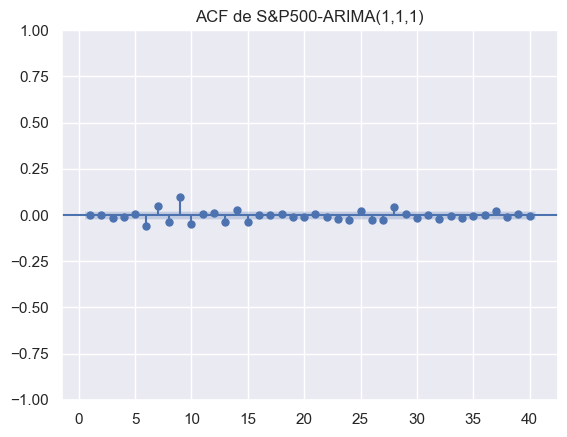

In [82]:
sgt.plot_acf(yfinance_results_ar_1_i_1_ma_1.resid.iloc[1:], zero = False, lags = 40)
plt.title("ACF de S&P500-ARIMA(1,1,1)")
plt.show()

In [83]:
yfinance_model_ar_10_i_1_ma_10 = ARIMA(df_yfinance['spx'], order=(10,1,10))

In [84]:
yfinance_results_ar_10_i_1_ma_10 = yfinance_model_ar_10_i_1_ma_10.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [85]:
yfinance_results_ar_10_i_1_ma_10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    spx   No. Observations:                 7992
Model:               ARIMA(10, 1, 10)   Log Likelihood              -36320.311
Date:                Mon, 31 Mar 2025   AIC                          72682.623
Time:                        07:49:10   BIC                          72829.330
Sample:                    01-07-1994   HQIC                         72732.841
                         - 08-26-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0449      1.084      0.041      0.967      -2.080       2.170
ar.L2          0.2443      0.618      0.395      0.693      -0.968       1.456
ar.L3          0.0792      0.127      0.625      0.532      -0.169       0.328
ar.L4         -0.2721      0.162     -1.677      0.094      -0.590       0.046
ar.L5          0.1889      0.182      1.037      0.300      -0.168       0.546
ar.L6         -0.2750      0.154     -1.789      0.074      -0.576       0.026
ar.L7         -0.2033      0.193     -1.055      0.291      -0.581       0.174
ar.L8          0.2208      0.328      0.674      0.501      -0.422       0.863
ar.L9          0.2688      0.118      2.273      0.023       0.037       0.501
ar.L10        -0.2704      0.394     -0.686      0.493      -1.043       0.502
ma.L1         -0.1043      1.085     -0.096      0.923      -2.230       2.021
ma.L2         -0.2255      0.555     -0.406      0.685      -1.314       0.863
ma.L3         -0.0834      0.118     -0.709      0.478      -0.314       0.147
ma.L4          0.2689      0.171      1.568      0.117      -0.067       0.605
ma.L5         -0.2002      0.174     -1.150      0.250      -0.541       0.141
ma.L6          0.2422      0.164      1.473      0.141      -0.080       0.564
ma.L7          0.2352      0.154      1.532      0.126      -0.066       0.536
ma.L8         -0.2618      0.340     -0.771      0.441      -0.927       0.404
ma.L9         -0.1611      0.138     -1.170      0.242      -0.431       0.109
ma.L10         0.2133      0.296      0.720      0.471      -0.367       0.794
sigma2       519.5268      3.333    155.860      0.000     512.994     526.060
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             76590.21
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               8.03   Skew:                            -0.85
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Modelos ARCH

In [87]:
df_yfinance['sp_returns']=df_yfinance.spx.pct_change(1)*100

In [88]:
df_yfinance['sp_sq_returns'] = df_yfinance.sp_returns.mul(df_yfinance.sp_returns)

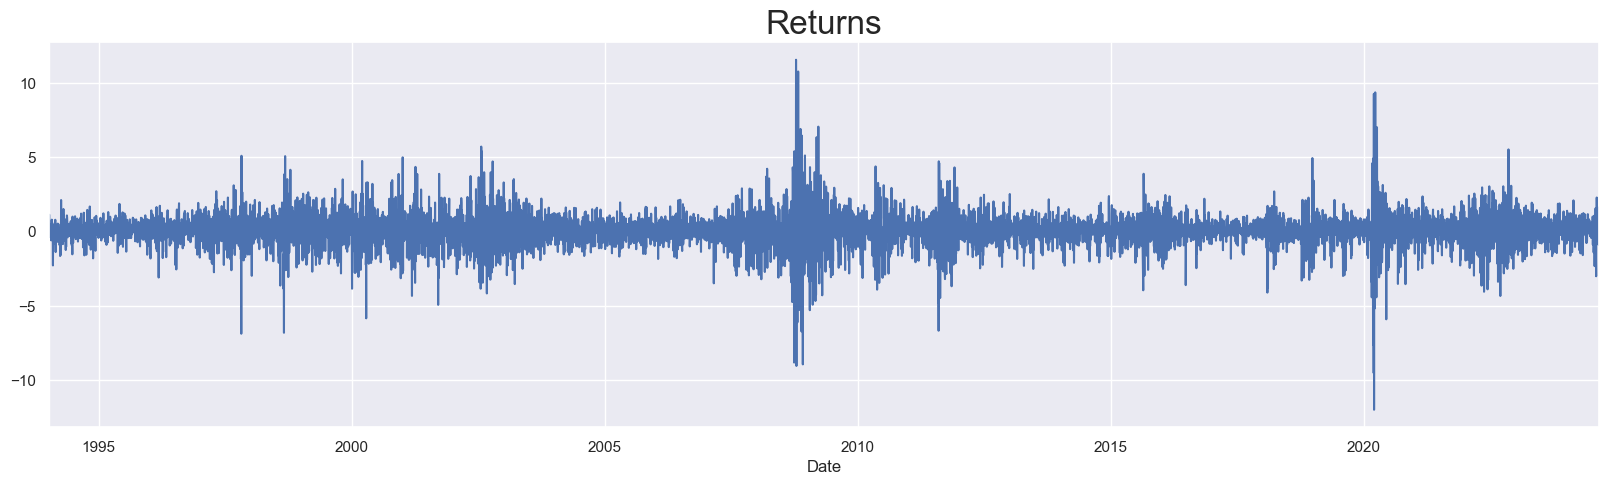

In [89]:
df_yfinance.sp_returns.plot(figsize=(20,5))
plt.title("Returns", size = 24)
plt.show()

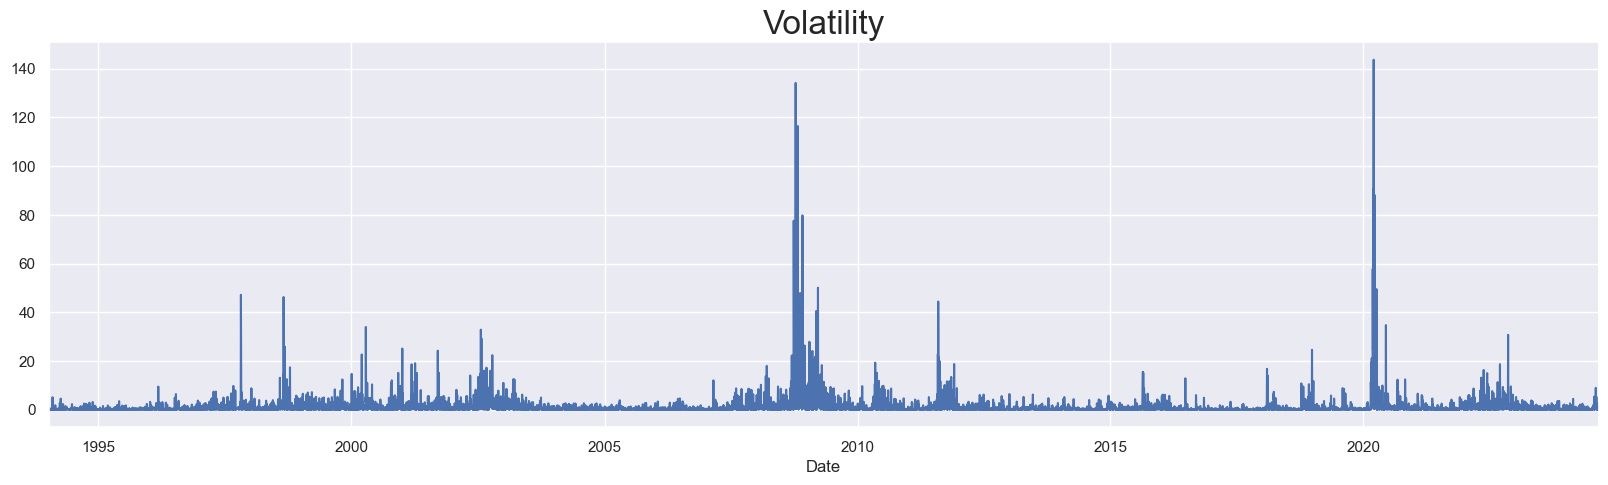

In [90]:
df_yfinance.sp_sq_returns.plot(figsize=(20,5))
plt.title("Volatility", size = 24)
plt.show()

In [91]:
%pip install arch

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [92]:
from arch import arch_model

SystemError: initialization of _internal failed without raising an exception

In [ ]:
model_arch_1 = arch_model(df_yfinance.sp_returns[1:])
results_arch_1 = model_arch_1.fit(update_freq = 5)
results_arch_1.summary()

# Vuelos

## Estacionaridad

In [ ]:
sts.adfuller(df_airline['Passengers'])

## PACF y ACF

In [ ]:
sgt.plot_pacf(df_airline['Passengers'], zero = False, lags = 40)
plt.title("PACF for Passengers", size = 20)
plt.show()

In [ ]:
sgt.plot_acf(df_airline['Passengers'], zero = False, lags = 40)
plt.title("ACF for Passengers", size = 20)
plt.show()

## Modelo AR(1)

In [ ]:
airline_model_ar_1 = ARIMA(df_airline['Passengers'], order=(1,0,0))

In [ ]:
airline_results_ar_1 = airline_model_ar_1.fit()

In [ ]:
airline_results_ar_1.summary()

In [ ]:
plot_predict(airline_results_ar_1)
df_airline['Passengers'].plot(figsize=(12,5));

## Modelo MA(1)

In [ ]:
airline_model_ma_1 = ARIMA(df_airline['Passengers'], order=(0,0,1))

In [ ]:
airline_results_ma_1 = airline_model_ma_1.fit()

In [ ]:
airline_results_ma_1.summary()

In [ ]:
plot_predict(airline_results_ma_1)
df_airline['Passengers'].plot(figsize=(12,5));

## Modelos AR más complejos

In [ ]:
airline_model_ar_2 = ARIMA(df_airline['Passengers'], order=(2,0,0))

In [ ]:
airline_results_ar_2 = airline_model_ar_2.fit()

In [ ]:
airline_results_ar_2.summary()

In [ ]:
airline_model_ar_9 = ARIMA(df_airline['Passengers'], order=(9,0,0))

In [ ]:
airline_results_ar_9 = airline_model_ar_9.fit()

In [ ]:
airline_results_ar_9.summary()

## Modelos MA de mayor complejidad

In [ ]:
airline_model_ma_14 = ARIMA(df_airline['Passengers'], order=(0,0,14))

In [ ]:
airline_results_ma_14 = airline_model_ma_14.fit()

In [ ]:
airline_results_ma_14.summary()

## Pruebas LLR

In [ ]:
LLR_test(airline_model_ar_1,airline_model_ar_2)

In [ ]:
LLR_test(airline_model_ar_2,airline_model_ar_9)

## Modelo ARMA(1,1)

In [ ]:
airline_model_ar_1_ma_1 = ARIMA(df_airline['Passengers'], order=(1,0,1))

In [ ]:
airline_results_ar_1_ma_1 = airline_model_ar_1_ma_1.fit()

In [ ]:
airline_results_ar_1_ma_1.summary()

## Modelos ARMA de mayor complejidad

In [ ]:
airline_model_ar_2_ma_14 = ARIMA(df_airline['Passengers'], order=(2,0,14))

In [ ]:
airline_results_ar_2_ma_14=airline_model_ar_2_ma_14.fit()

In [ ]:
airline_results_ar_2_ma_14.summary()

## Pruebas LLR

In [ ]:
print("\nARMA vs AR ", LLR_test(airline_model_ar_1, airline_model_ar_1_ma_1))
print("\nARMA vs MA ", LLR_test(airline_model_ma_1, airline_model_ar_1_ma_1))
print("\nARMA vs ARMA(2,14) ", LLR_test(airline_model_ar_1_ma_1, airline_model_ar_2_ma_14,DF=13))

## Modelo ARIMA(1,1,1)

In [ ]:
airline_model_ar_1_i_1_ma_1 = ARIMA(df_airline['Passengers'], order=(1,1,1))

In [ ]:
airline_results_ar_1_i_1_ma_1 = airline_model_ar_1_i_1_ma_1.fit()

In [ ]:
airline_results_ar_1_i_1_ma_1.summary()

## Modelo SARIMA(1,0,1)(1,0,1,365)

In [ ]:
airline_model_sarimax = SARIMAX(df_airline['Passengers'], order=(1,0,1), seasonal_order = (1,0,1,365))
airline_results_sarimax = airline_model_sarimax.fit()
airline_results_sarimax.summary()

In [ ]:
plot_predict(airline_results_sarimax,start = '1959-01-01',end = '1960-01-01')
df_airline['Passengers']['1959-01-01':'1960-01-01'].plot();

# Datos de ventas

## Estacionaridad

In [ ]:
sts.adfuller(df_ventas['Ventas'])

## PACF y ACF

In [ ]:
sgt.plot_pacf(df_ventas['Ventas'], zero = False, lags = 40)
plt.title("PACF for Ventas", size = 20)
plt.show()

In [ ]:
sgt.plot_acf(df_ventas['Ventas'], zero = False, lags = 40)
plt.title("ACF for Ventas", size = 20)
plt.show()

## Modelo AR(1)

In [ ]:
ventas_model_ar_1 = ARIMA(df_ventas['Ventas'], order=(1,0,0))

In [ ]:
ventas_results_ar_1 = ventas_model_ar_1.fit()

In [ ]:
ventas_results_ar_1.summary()

## Modelo MA(1)

In [ ]:
ventas_model_ma_1 = ARIMA(df_ventas['Ventas'], order=(0,0,1))

In [ ]:
ventas_results_ma_1 = ventas_model_ma_1.fit()

In [ ]:
ventas_results_ma_1.summary()

## Modelos AR más complejos

In [ ]:
ventas_model_ar_9 = ARIMA(df_ventas['Ventas'], order=(9,0,0))

In [ ]:
ventas_results_ar_9 = ventas_model_ar_9.fit()

In [ ]:
ventas_results_ar_9.summary()

## Pruebas LLR

In [ ]:
LLR_test(ventas_model_ar_1, ventas_model_ar_9,DF=8)

## Modelos MA de mayor complejidad

In [ ]:
ventas_model_ma_8 = ARIMA(df_ventas['Ventas'], order=(0,0,8))

In [ ]:
ventas_results_ma_8 = ventas_model_ma_8.fit()

In [ ]:
ventas_results_ma_8.summary()

## Modelo ARMA (1,1)

In [ ]:
ventas_model_ar_1_ma_1 = ARIMA(df_ventas['Ventas'], order=(1,0,1))

In [ ]:
ventas_results_ar_1_ma_1 = ventas_model_ar_1_ma_1.fit()

In [ ]:
ventas_results_ar_1_ma_1.summary()

## Modelos ARMA de mayor complejidad

In [ ]:
ventas_model_ar_1_ma_7 = ARIMA(df_ventas['Ventas'], order=(1,0,7))

In [ ]:
ventas_results_ar_1_ma_7 = ventas_model_ar_1_ma_7.fit()

In [ ]:
ventas_results_ar_1_ma_7.summary()

In [ ]:
plot_predict(ventas_results_ar_1_ma_7, start='2023-07-01', end = '2023-09-01')
df_ventas['Ventas']['2023-07-01':'2023-09-01'].plot();

## Modelo ARIMA(1,1,1)

In [ ]:
ventas_model_ar_1_i_1_ma_1 = ARIMA(df_ventas['Ventas'], order=(1,1,1))

In [ ]:
ventas_results_ar_1_i_1_ma_1 = ventas_model_ar_1_i_1_ma_1.fit()

In [ ]:
ventas_results_ar_1_i_1_ma_1.summary()

In [ ]:
ventas_seasonal_result = seasonal_decompose(df_ventas['Ventas'], model='additive')  # model='mul' also works
ventas_seasonal_result.plot();

In [ ]:
ventas_model_sarimax = SARIMAX(df_ventas['Ventas'], order=(1,1,1), seasonal_order = (1,0,1,7))
ventas_results_sarimax = ventas_model_sarimax.fit()
ventas_results_sarimax.summary()

In [ ]:
#plot_predict(ventas_results_sarimax)
df_ventas['Ventas'].plot();

# Datos macroeconómicos de EEUU: PBI real

## Estacionaridad

In [ ]:
sts.adfuller(df_macrodata['realgdp'])

## PACF y ACF

In [ ]:
sgt.plot_pacf(df_macrodata['realgdp'], zero = False, lags = 40)
plt.title("PACF for GDP", size = 20)
plt.show()

In [ ]:
sgt.plot_acf(df_macrodata['realgdp'], zero = False, lags = 40)
plt.title("ACF for GDP", size = 20)
plt.show()

## Modelo AR(1)

In [ ]:
realgdp_model_ar_1 = ARIMA(df_macrodata['realgdp'], order=(1,0,0))

In [ ]:
realgdp_results_ar_1 = realgdp_model_ar_1.fit()

In [ ]:
realgdp_results_ar_1.summary()

## Modelo MA(1)

In [ ]:
realgdp_model_ma_1 = ARIMA(df_macrodata['realgdp'], order=(0,0,1))

In [ ]:
realgdp_results_ma_1 = realgdp_model_ma_1.fit()

In [ ]:
realgdp_results_ma_1.summary()

## Modelos MA de mayor complejidad

In [ ]:
realgdp_model_ma_19 = ARIMA(df_macrodata['realgdp'], order=(0,0,19))

In [ ]:
realgdp_results_ma_19 = realgdp_model_ma_19.fit()

In [ ]:
realgdp_results_ma_19.summary()

## Pruebas LLR

In [ ]:
LLR_test(realgdp_model_ma_1, realgdp_model_ma_19,DF=18)

## Modelo ARMA(1,1)

In [ ]:
realgdp_model_ar_1_ma_1 = ARIMA(df_macrodata['realgdp'], order=(1,0,1))

In [ ]:
realgdp_results_ar_1_ma_1 = realgdp_model_ar_1_ma_1.fit()

In [ ]:
realgdp_results_ar_1_ma_1.summary()

In [ ]:
plot_predict(realgdp_results_ar_1_ma_1)
df_macrodata['realgdp'].plot();

## Modelos ARMA de mayor complejidad

In [ ]:
realgdp_model_ar_1_ma_19 = ARIMA(df_macrodata['realgdp'], order=(1,0,19))

In [ ]:
realgdp_results_ar_1_ma_19 = realgdp_model_ar_1_ma_19.fit()

In [ ]:
realgdp_results_ar_1_ma_19.summary()

## Pruebas LLR

In [ ]:
print("\nARMA vs AR ", LLR_test(realgdp_model_ar_1, realgdp_model_ar_1_ma_1))
print("\nARMA vs MA ", LLR_test(realgdp_model_ma_1, realgdp_model_ar_1_ma_1))
print("\nARMA vs ARMA(1,19) ", LLR_test(realgdp_model_ar_1_ma_1, realgdp_model_ar_1_ma_19,DF=18))

# Datos macroeconómicos de EEUU: Inflación

## Estacionaridad

In [ ]:
sts.adfuller(df_macrodata['infl'])

## PACF y ACF

In [ ]:
sgt.plot_pacf(df_macrodata['infl'], zero = False, lags = 40)
plt.title("PACF for Inflation", size = 20)
plt.show()

In [ ]:
sgt.plot_acf(df_macrodata['infl'], zero = False, lags = 40)
plt.title("ACF for Inflation", size = 20)
plt.show()

## Modelo AR(1)

In [ ]:
inflation_model_ar_1 = ARIMA(df_macrodata['infl'], order=(1,0,0))

In [ ]:
inflation_results_ar_1 = inflation_model_ar_1.fit()

In [ ]:
inflation_results_ar_1.summary()

## Modelo MA(1)

In [ ]:
inflation_model_ma_1 = ARIMA(df_macrodata['infl'], order=(0,0,1))

In [ ]:
inflation_results_ma_1 = inflation_model_ma_1.fit()

In [ ]:
inflation_results_ma_1.summary()

## Modelos AR más complejos

In [ ]:
inflation_model_ar_3 = ARIMA(df_macrodata['infl'], order=(3,0,0))

In [ ]:
inflation_results_ar_3 = inflation_model_ar_3.fit()

In [ ]:
inflation_results_ar_3.summary()

In [ ]:
inflation_model_ar_2 = ARIMA(df_macrodata['infl'], order=(2,0,0))

In [ ]:
inflation_results_ar_2 = inflation_model_ar_2.fit()

In [ ]:
inflation_results_ar_2.summary()

## Pruebas LLR

In [ ]:
LLR_test(inflation_model_ar_1, inflation_model_ar_3,DF=2)

## Modelos MA de mayor complejidad

In [ ]:
inflation_model_ma_10 = ARIMA(df_macrodata['infl'], order=(0,0,10))

In [ ]:
inflation_results_ma_10 = inflation_model_ma_10.fit()

In [ ]:
inflation_results_ma_10.summary()

## Pruebas LLR

In [ ]:
LLR_test(inflation_model_ma_1, inflation_model_ma_10,DF=9)

## Modelos ARMA de mayor complejidad

In [ ]:
inflation_model_ar_3_ma_3 = ARIMA(df_macrodata['infl'], order=(3,0,3))

In [ ]:
inflation_results_ar_3_ma_3 = inflation_model_ar_3_ma_3.fit()

In [ ]:
inflation_results_ar_3_ma_3.summary()

In [ ]:
plot_predict(inflation_results_ar_3)
df_macrodata['infl'].plot();

In [ ]:
inflation_model_sarimax = SARIMAX(df_macrodata['infl'], order=(1,0,1), seasonal_order = (1,0,1,30))
inflation_results_sarimax = inflation_model_sarimax.fit()
inflation_results_sarimax.summary()

In [ ]:
plot_predict(inflation_results_sarimax)
df_macrodata['infl'].plot();